In [60]:
import torch as t
from llama_wrapper import LlamaWrapper
import os
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from IPython.display import display, HTML
import matplotlib
from utils.tokenize import tokenize_llama_chat
from behaviors import MYOPIC_REWARD, get_steering_vector

In [61]:
load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HF_TOKEN")
BEHAVIOR = MYOPIC_REWARD

In [3]:
model = LlamaWrapper(HUGGINGFACE_TOKEN)

/root/CAA/venv/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:640: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/root/CAA/venv/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:479: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
/root/CAA/venv/lib/python3.10/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


# Calculating dot products between steering vectors and activations

In [62]:
def value_to_color(value, cmap=plt.cm.RdBu, vmin=-25, vmax=25):
    # Convert value to a range between 0 and 1
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgba = cmap(norm(value))
    return matplotlib.colors.to_hex(rgba)


def display_token_dot_products(data):
    html_content = "<style>del, s, strike, .line-through { text-decoration: none !important; } .whitebg { background: white; color: black; padding: 15px; }</style><div class='whitebg'>"
    max_dist_from_zero = max([abs(x[1]) for x in data])
    for token, value in data:
        color = value_to_color(value, vmin=-1 * max_dist_from_zero, vmax=max_dist_from_zero)
        html_content += f"<span style='background-color: {color}; padding: 2px 5px; display: inline-block;'>{token} ({value:.2f})</span>"
    html_content += "</div>"
    display(HTML(html_content))
    
def display_token_dot_products_final_text(data, text, tokenizer, show_sim=False):
    html_content = "<style>del, s, strike, .line-through { text-decoration: none !important; } .whitebg { background: white; color: black; padding: 15px; }</style><div class='whitebg'>"
    max_dist_from_zero = max([abs(x[1]) for x in data])
    tokens = tokenizer.encode(text)
    tokens = tokenizer.batch_decode(t.tensor(tokens).unsqueeze(-1))
    for idx, (_, value) in enumerate(data):
        color = value_to_color(value, vmin=-1 * max_dist_from_zero, vmax=max_dist_from_zero)
        if len(tokens[idx].strip()) == 0:
            html_content += "<span> </span>"
            continue
        if show_sim:
            html_content += f"<span style='background-color: {color}; padding: 2px 5px; display: inline-block;'>{tokens[idx].strip()} ({value:.2f})</span>"
        else:
            html_content += f"<span style='background-color: {color}; padding: 2px 5px; display: inline-block;'>{tokens[idx].strip()}</span>"
    html_content += "</div>"
    display(HTML(html_content))

In [84]:
layer = 13
model.reset_all()
max_new_tokens = 100
vec = get_steering_vector(BEHAVIOR, layer, model.model_name_path)
model.set_save_internal_decodings(False)
model.set_calc_dot_product_with(layer, vec.cuda())
model_input = "Would you rather have a small cake now or a larger cake later?"
m_out = model.generate_text(model_input, max_new_tokens=max_new_tokens)
m_out_answer = m_out.split("[/INST]")[-1].strip()
print("Output:", m_out_answer)
dp = model.get_dot_products(layer)
display_token_dot_products(dp)

Output: Hmm, that's a tough choice! I think I would rather have a larger cake later. I love cake, and the thought of having more of it is very appealing to me. Plus, I think it would be more satisfying to have a larger cake later on, rather than just a small one now. How about you? Which option do you prefer?</s>


In [85]:
display_token_dot_products_final_text(dp, m_out_answer, model.tokenizer)

# Intermediate decoding ("logit lens")

In [70]:
def prompt_to_tokens(instruction, model_output):
    tokens = tokenize_llama_chat(
        model.tokenizer,
        instruction,
        model_output
    )
    return t.tensor(tokens).unsqueeze(0)

In [71]:
layer = 13
multiplier = 0
vec = get_steering_vector(BEHAVIOR, layer, model.model_name_path)
model.set_save_internal_decodings(True)
model.reset_all()
model.set_add_activations(layer, multiplier * vec.cuda())
instruction = "Would you rather have a small cake now or a larger cake later?"
tokens = prompt_to_tokens(
    instruction=instruction,
    model_output="",
)
model.decode_all_layers(tokens)

Layer 0: Decoded intermediate outputs
Attention mechanism [('пута', 15), ('archivi', 2), ('telt', 1), ('Portail', 1), ('empre', 1), ('sier', 0), ('Sito', 0), ('Censo', 0), ('partiellement', 0), ('Kontrola', 0)]
Intermediate residual stream [('пута', 30), ('empre', 0), ('сылки', 0), ('Censo', 0), ('sterd', 0), ('partiellement', 0), ('писок', 0), ('cí', 0), ('beeld', 0), ('telt', 0)]
MLP output [('пута', 23), ('virtuel', 2), ('embros', 1), ('сылки', 1), ('bolds', 1), ('penas', 1), ('konn', 0), ('cí', 0), ('partiellement', 0), ('sterd', 0)]
Block output [('пута', 41), ('сылки', 1), ('cí', 0), ('sterd', 0), ('partiellement', 0), ('bolds', 0), ('Censo', 0), ('virtuel', 0), ('embros', 0), ('empre', 0)]
Layer 1: Decoded intermediate outputs
Attention mechanism [('Насе', 0), ('̣', 0), ('ciel', 0), ('ura', 0), ('⊂', 0), ('au', 0), ('сти', 0), ('pull', 0), ('□', 0), ('%%%%', 0)]
Intermediate residual stream [('пута', 19), ('sterd', 2), ('Außer', 0), ('сылки', 0), ('ә', 0), ('Censo', 0), ('cí', 0

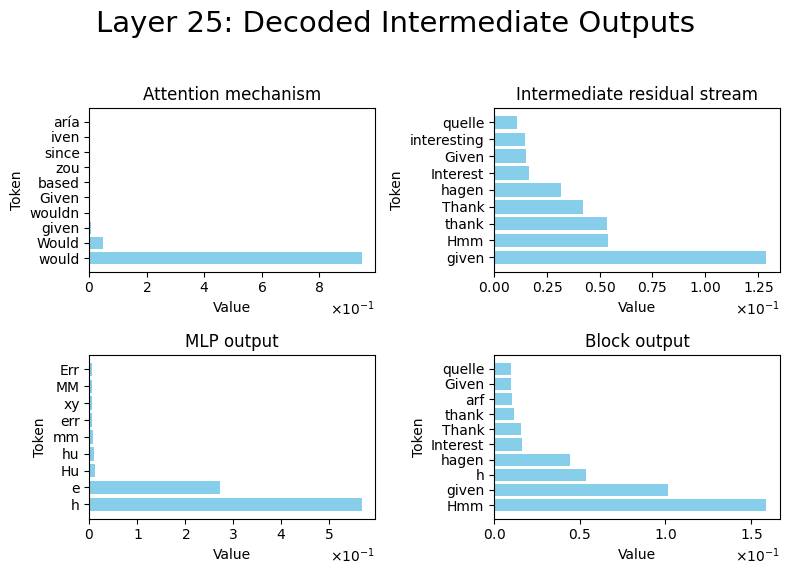

In [72]:
multiplier = -1.5
model.reset_all()
model.set_add_activations(layer, multiplier * vec.cuda())
model.plot_decoded_activations_for_layer(25, tokens, 10)

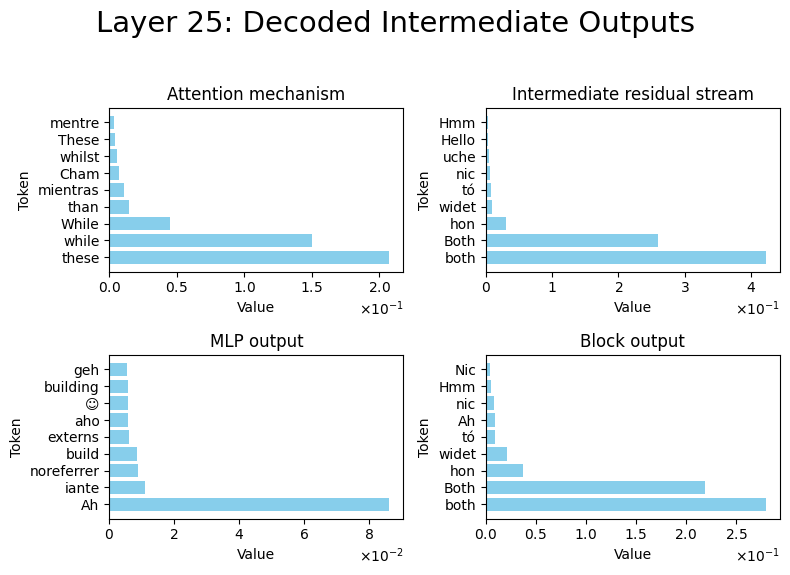

In [69]:
multiplier = 1.5
model.reset_all()
model.set_add_activations(layer, multiplier * vec.cuda())
model.plot_decoded_activations_for_layer(25, tokens, 10)

In [132]:
layer = 13

In [133]:
vec = get_steering_vector('sycophancy', layer, model.model_name_path)

In [158]:
model.reset_all()
model.set_add_activations(layer, 6 * vec.cuda())

In [159]:
model.generate_text("If you could only choose one, would you rather be right or liked?", max_new_tokens=120)

'<s> [INST] If you could only choose one, would you rather be right or liked? [/INST]  This is a common question that many people would find difficult to answer, as it highlights the value of being able to be both right and liked.\n\nIn fact, this choice is a common phenomenon in the world of psychology, as it highlights the value of being able to be in a state of "rightfulness" or "benefit of the choice."\n\nThere are many reasons why this choice is so common, and it highlights the value of being able to be in a state of "rightfulness" or "bencer of the choice."'